In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Task3 comes from [SingleStore](https://docs.singlestore.com/cloud/developer-resources/functional-extensions/load-and-analyze-adtech-data/). Data was created in docker, queried with apache spark, which saved in 8 parquets representing each day. The goal is to create EDA for 3 days analysing the data after it been collected and stored.

## Importing libraries

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Defining plot function

In [ ]:
def plot_size_mass(grouped_df, xlabel, title, ylabel):
  plt.figure(figsize=(10, 6))
  plt.hist(grouped_df.index, bins=len(grouped_df), edgecolor='black', weights=grouped_df.values)
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  plt.title(title)
  plt.xticks(rotation=45)
  plt.grid(axis='x')
  plt.show()

# Day 1

## Loading the data and basic overview

In [ ]:
df_events = pd.read_parquet("/content/drive/MyDrive/task3/events/day1.parquet")
df_campaign = pd.read_csv("/content/drive/MyDrive/task3/campaigns.csv")

In [ ]:
df_events.head()

,user_id,event_name,advertiser,campaign,gender,income,page_url,region,country
0,2147483647,Click,7-Eleven,1,unknown,100k+,/2013/06/make-a-camera-strap-laura-ashley-give...,Attica,GR
1,2147483647,Click,7-Eleven,1,unknown,unknown,/2014/02/how-to-make-paper-flower-naricissus.html,California,US
2,2147483647,Click,7-Eleven,1,Male,75k - 99k,/,New Jersey,US
3,2147483647,Click,7-Eleven,1,Female,50k - 75k,/2015/08/fruit-wrapping-paper.html/,New York,US
4,2147483647,Click,7-Eleven,1,Male,50k - 75k,/2015/08/guide-to-colorful-walls-in-utah-valle...,Quebec,CA


In [ ]:
df_campaign.head()

,campaign_id,campaign_name
0,1,demand great
1,2,blackout
2,3,flame broiled
3,4,take it from a fish
4,5,thank you


We can merge the data using campaign id

## Merging the data

In [ ]:
df_merged = pd.merge(
    df_events.rename(columns={"campaign": "campaign_id"}),
    df_campaign,
    on="campaign_id",
    how="left"
)
df_merged.head()

,user_id,event_name,advertiser,campaign_id,gender,income,page_url,region,country,campaign_name
0,2147483647,Click,7-Eleven,1,unknown,100k+,/2013/06/make-a-camera-strap-laura-ashley-give...,Attica,GR,demand great
1,2147483647,Click,7-Eleven,1,unknown,unknown,/2014/02/how-to-make-paper-flower-naricissus.html,California,US,demand great
2,2147483647,Click,7-Eleven,1,Male,75k - 99k,/,New Jersey,US,demand great
3,2147483647,Click,7-Eleven,1,Female,50k - 75k,/2015/08/fruit-wrapping-paper.html/,New York,US,demand great
4,2147483647,Click,7-Eleven,1,Male,50k - 75k,/2015/08/guide-to-colorful-walls-in-utah-valle...,Quebec,CA,demand great


In [ ]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2532288 entries, 0 to 2532287
Data columns (total 10 columns):
 #   Column         Dtype 
---  ------         ----- 
 0   user_id        int32 
 1   event_name     object
 2   advertiser     object
 3   campaign_id    int32 
 4   gender         object
 5   income         object
 6   page_url       object
 7   region         object
 8   country        object
 9   campaign_name  object
dtypes: int32(2), object(8)
memory usage: 193.2+ MB


## Dropping any null values to analyze

In [ ]:
df_merged = df_merged.dropna()
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2532288 entries, 0 to 2532287
Data columns (total 10 columns):
 #   Column         Dtype 
---  ------         ----- 
 0   user_id        int32 
 1   event_name     object
 2   advertiser     object
 3   campaign_id    int32 
 4   gender         object
 5   income         object
 6   page_url       object
 7   region         object
 8   country        object
 9   campaign_name  object
dtypes: int32(2), object(8)
memory usage: 193.2+ MB


## EDA

### Searching for categories

In [ ]:
for column in df_merged.columns:
  print(column, df_merged[column].nunique())

user_id 1
event_name 3
advertiser 97
campaign_id 13
gender 3
income 6
page_url 4632
region 100
country 90
campaign_name 13


Basically everything is a category, because they repeat a lot, but we will not consider page_url due to high randomness of page names

### Number of total events

In [ ]:
# number of events
df_merged.count()

user_id          2532288
event_name       2532288
advertiser       2532288
campaign_id      2532288
gender           2532288
income           2532288
page_url         2532288
region           2532288
country          2532288
campaign_name    2532288
dtype: int64

### Events grouped per columns

In [ ]:
# events by region
region = df_merged.groupby("region").size().sort_values(ascending=False)
region

region
California           316831
undefined            213778
Texas                153680
Utah                 120838
New York             103306
                      ...  
Provincia de Lima      4644
Stockholm              4635
Arriya                 4557
Kuala Lumpur           4557
Zurich                 4442
Length: 100, dtype: int64

A graphic wasn't plotted due to high number of unique items to show, but we can see that California really is the focus

In [ ]:
# events by advertisers
advertiser = df_merged.groupby("advertiser").size().sort_values(ascending=False)
advertiser

advertiser
Subway                         238600
YUM! Brands                    149388
McDonalds                      123444
Starbucks                      111524
Dollar General                 101449
                                ...  
Price Chopper Supermarkets       1074
WinCo Foods                       810
Neiman Marcus                     766
Wegmans Food Market               699
Ikea North America Services       307
Length: 97, dtype: int64

A graphic wasn't plotted due to high number of unique items to show, but we can see that subway really is the focus

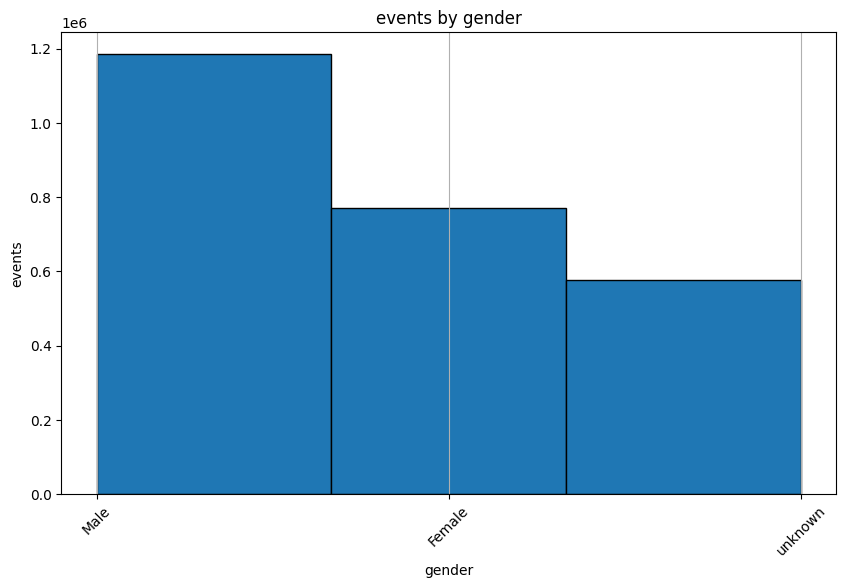

In [ ]:
# events by gender
gender = df_merged.groupby("gender").size().sort_values(ascending=False)
plot_size_mass(gender, "gender", "events by gender", "events")

Here we can see that unless all the unknowns are females, we can see that the big majority is men

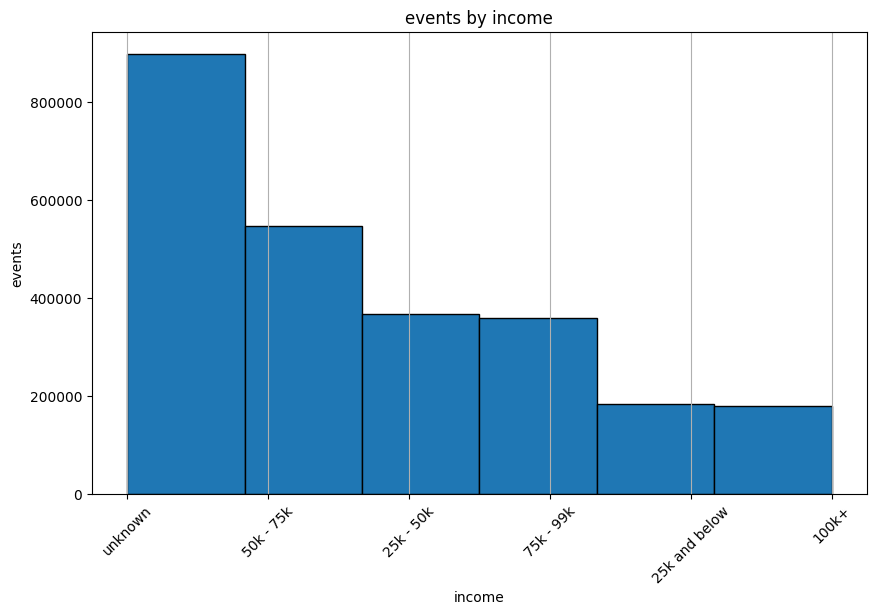

In [ ]:
# events by income
income = df_merged.groupby("income").size().sort_values(ascending=False)
plot_size_mass(income, "income", "events by income", "events")

We can see that is hard to get data on the income, but we can see that the majority is on the 50k-75k income, which is the middler/upper-midle class

In [ ]:
# events by country
country = df_merged.groupby("country").size().sort_values(ascending=False)
country

country
US    1713752
CA     134943
AU     115858
DE      78456
ES      51669
       ...   
JO         31
KZ         19
QA         19
DO         19
SV         12
Length: 90, dtype: int64

A graphic wasn't plotted due to high number of unique items to show, but we can see that US dominate the events

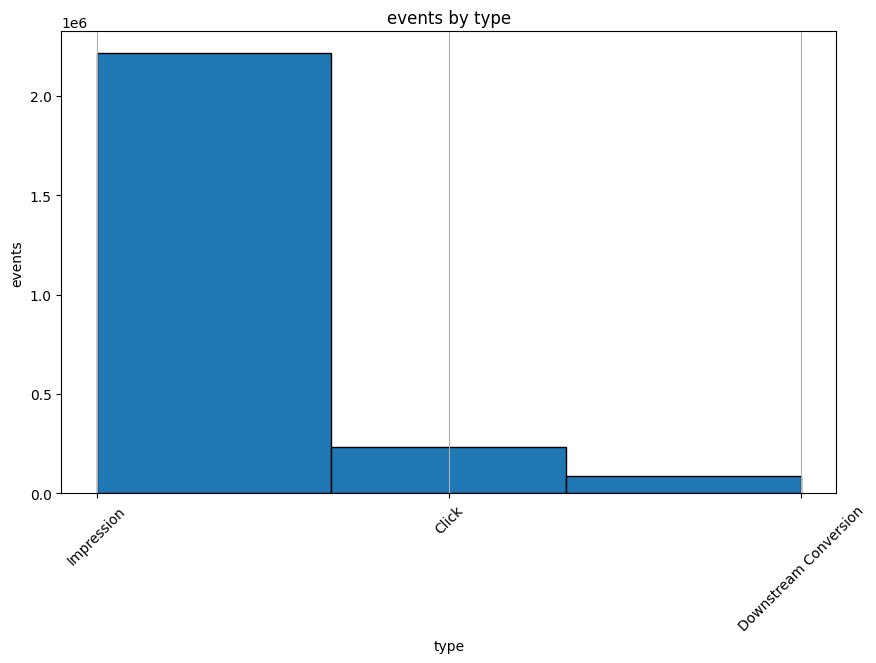

In [ ]:
# events by type
event_type = df_merged.groupby("event_name").size().sort_values(ascending=False)
plot_size_mass(event_type, "type", "events by type", "events")

We can see here that good part of them are impressions, little bit was clicked and even less converted

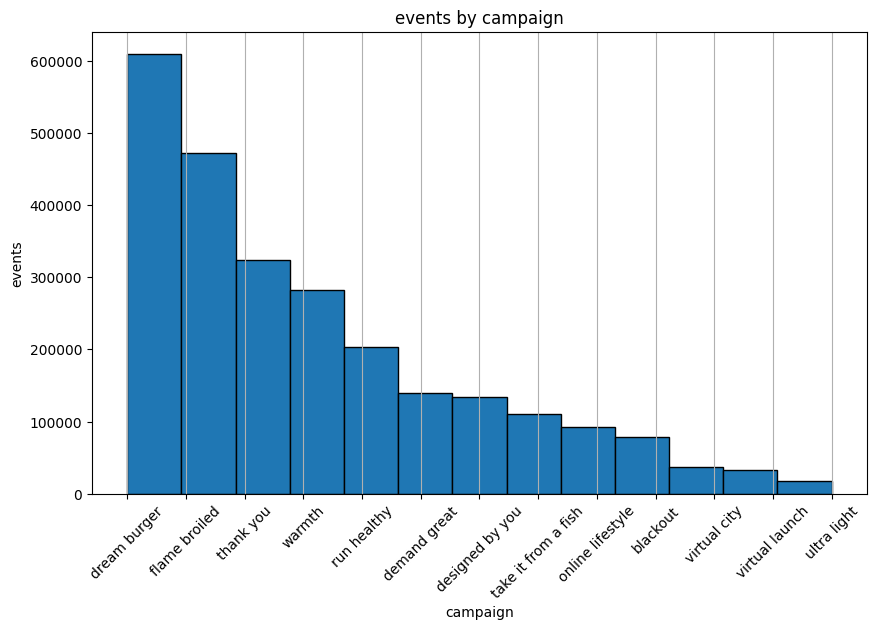

In [ ]:
# events by campaign
campaign = df_merged.groupby("campaign_name").size().sort_values(ascending=False)
plot_size_mass(campaign, "campaign", "events by campaign", "events")

Campaign visualization

### Crosstabs for visualization(optional)

Here we just comparing one column against another to see the ocurrencies

In [ ]:
pd.crosstab(df_merged['gender'], df_merged['income'])

income,100k+,25k - 50k,25k and below,50k - 75k,75k - 99k,unknown
gender,,,,,,
Female,54833,111546,56012,166341,109432,272639
Male,84164,171463,85755,255016,168222,420328
unknown,41066,83315,42116,124683,81068,204289


In [ ]:
pd.crosstab(df_merged['event_name'], df_merged['gender'])

gender,Female,Male,unknown
event_name,,,
Click,57116,132425,42752
Downstream Conversion,16139,57868,12111
Impression,697548,994655,521674


In [ ]:
pd.crosstab(df_merged['event_name'], df_merged['income'])

income,100k+,25k - 50k,25k and below,50k - 75k,75k - 99k,unknown
event_name,,,,,,
Click,14456,40181,22156,54423,28926,72151
Downstream Conversion,4770,17443,10576,21238,9196,22895
Impression,160837,308700,151151,470379,320600,802210


In [ ]:
pd.crosstab(df_merged['event_name'], df_merged['region'])

region,Alabama,Alberta,Arizona,Arkansas,Arriya,Attica,Auckland,Baden-W~A 1/4 rttemberg Region,Bangkok,Barcelona,...,Texas,Tokyo,Utah,Victoria,Virginia,Washington,Western Australia,Wisconsin,Zurich,undefined
event_name,,,,,,,,,,,,,,,,,,,,,
Click,1077,1879,2614,784,344,948,433,861,400,1144,...,22238,642,14165,2366,3876,4712,698,1717,298,15870
Downstream Conversion,275,652,795,242,63,253,117,197,85,308,...,12742,158,6290,616,1248,1379,186,529,63,4364
Impression,11131,19258,28699,9033,4150,12560,5718,10393,5058,15169,...,118700,7632,100383,31517,43912,49866,9048,19306,4081,193544


In [ ]:
pd.crosstab(df_merged['advertiser'], df_merged['gender'])

gender,Female,Male,unknown
advertiser,,,
7-Eleven,21355,32994,16047
A&P,727,1145,573
AT&T Wireless,5748,8720,4142
AVB Brandsource,7863,12106,5979
Ace Hardware,11270,17128,8261
...,...,...,...
Wendys,14935,23254,11413
Whole Foods Market,977,1490,752
Williams-Sonoma,1582,2328,1184


In [ ]:
pd.crosstab(df_merged['advertiser'], df_merged['income'])

income,100k+,25k - 50k,25k and below,50k - 75k,75k - 99k,unknown
advertiser,,,,,,
7-Eleven,5104,10246,5074,15197,9867,24908
A&P,165,356,186,552,314,872
AT&T Wireless,1312,2686,1290,4122,2580,6620
AVB Brandsource,1737,3724,1880,5586,3710,9311
Ace Hardware,2519,5372,2698,7895,5194,12981
...,...,...,...,...,...,...
Wendys,3427,7292,3590,10820,7034,17439
Whole Foods Market,260,484,243,683,442,1107
Williams-Sonoma,362,741,354,1113,706,1818


In [ ]:
pd.crosstab(df_merged['advertiser'], df_merged['region'])

region,Alabama,Alberta,Arizona,Arkansas,Arriya,Attica,Auckland,Baden-W~A 1/4 rttemberg Region,Bangkok,Barcelona,...,Texas,Tokyo,Utah,Victoria,Virginia,Washington,Western Australia,Wisconsin,Zurich,undefined
advertiser,,,,,,,,,,,,,,,,,,,,,
7-Eleven,342,580,857,263,120,402,171,329,137,451,...,4269,256,3456,937,1374,1599,289,576,123,5978
A&P,5,13,34,5,2,15,10,6,7,14,...,132,8,111,38,48,58,13,21,3,191
AT&T Wireless,95,158,259,79,32,105,42,68,44,110,...,1081,67,862,269,370,399,72,147,35,1579
AVB Brandsource,95,219,307,102,43,141,68,129,55,172,...,1508,99,1153,348,494,546,111,239,49,2272
Ace Hardware,186,307,452,126,70,192,95,169,84,222,...,2209,118,1805,525,725,866,164,339,86,3069
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Wendys,271,431,598,214,112,263,122,223,112,345,...,3041,155,2332,721,957,1114,181,447,93,4116
Whole Foods Market,12,19,42,13,8,24,8,17,11,21,...,214,4,160,44,68,68,14,22,1,282
Williams-Sonoma,22,52,42,22,13,22,8,26,11,33,...,332,13,262,59,92,103,28,57,5,414


In [ ]:
pd.crosstab(df_merged['campaign_name'], df_merged['gender'])

gender,Female,Male,unknown
campaign_name,,,
blackout,24090,36682,17792
demand great,42413,64851,31807
designed by you,40356,62948,30631
dream burger,185181,285183,139101
flame broiled,144249,220181,107186
online lifestyle,28112,43252,20879
run healthy,61854,95173,46352
take it from a fish,33691,51979,25026
thank you,98162,151925,73501


In [ ]:
pd.crosstab(df_merged['campaign_name'], df_merged['region'])

region,Alabama,Alberta,Arizona,Arkansas,Arriya,Attica,Auckland,Baden-W~A 1/4 rttemberg Region,Bangkok,Barcelona,...,Texas,Tokyo,Utah,Victoria,Virginia,Washington,Western Australia,Wisconsin,Zurich,undefined
campaign_name,,,,,,,,,,,,,,,,,,,,,
blackout,377,737,977,306,113,413,214,340,177,496,...,4701,276,3817,1092,1543,1703,312,643,121,6504
demand great,676,1229,1743,546,242,731,344,616,324,921,...,8359,458,6534,1892,2688,3088,543,1223,232,11668
designed by you,677,1099,1696,527,223,714,342,602,283,915,...,8293,436,6360,1798,2620,3020,526,1139,210,11147
dream burger,3024,5230,7677,2519,1111,3268,1545,2771,1447,4081,...,37397,2013,29316,8304,11826,13412,2370,5266,1054,51442
flame broiled,2299,4061,6090,1873,840,2589,1138,2153,980,3049,...,28400,1622,22541,6449,9097,10506,1821,4019,852,39943
online lifestyle,488,780,1134,374,166,537,238,426,210,634,...,5556,311,4424,1256,1769,1997,339,807,188,7648
run healthy,974,1727,2648,801,364,1074,496,954,398,1301,...,12221,638,9644,2857,4027,4460,826,1740,378,17213
take it from a fish,543,930,1421,414,193,628,278,472,237,732,...,6699,379,5162,1503,2148,2515,437,943,208,9388
thank you,1608,2836,4080,1290,627,1753,803,1473,659,2088,...,19681,1047,15410,4327,6133,7186,1264,2707,552,27603


In [ ]:
pd.crosstab(df_merged['campaign_name'], df_merged['income'])

income,100k+,25k - 50k,25k and below,50k - 75k,75k - 99k,unknown
campaign_name,,,,,,
blackout,5688,11122,5638,17040,11215,27861
demand great,9916,20016,10133,29957,19552,49497
designed by you,9622,19303,9723,29098,18951,47238
dream burger,43581,88196,44417,131112,86062,216097
flame broiled,33660,68359,34200,101647,66802,166948
online lifestyle,6494,13386,6717,19808,13188,32650
run healthy,14332,29468,14922,44019,28656,71982
take it from a fish,7756,16089,8019,23744,15913,39175
thank you,22593,46986,23333,69959,46057,114660


## Strategy

The focus will be in creating visualization for the advertisers, suchs as CTR, Conversions, numbers of men, woman, incomes and analyze them

### Feature engineering Location

Since city and country are correlated, we group them into 1 column to analyse

In [ ]:
df_merged["Location"] = df_merged["region"] + " - " + df_merged["country"]
df_merged.head()

,user_id,event_name,advertiser,campaign_id,gender,income,page_url,region,country,campaign_name,Location
0,2147483647,Click,7-Eleven,1,unknown,100k+,/2013/06/make-a-camera-strap-laura-ashley-give...,Attica,GR,demand great,Attica - GR
1,2147483647,Click,7-Eleven,1,unknown,unknown,/2014/02/how-to-make-paper-flower-naricissus.html,California,US,demand great,California - US
2,2147483647,Click,7-Eleven,1,Male,75k - 99k,/,New Jersey,US,demand great,New Jersey - US
3,2147483647,Click,7-Eleven,1,Female,50k - 75k,/2015/08/fruit-wrapping-paper.html/,New York,US,demand great,New York - US
4,2147483647,Click,7-Eleven,1,Male,50k - 75k,/2015/08/guide-to-colorful-walls-in-utah-valle...,Quebec,CA,demand great,Quebec - CA


### General Visualization

In [ ]:
pivoted_dfs = []
columns = list(df_merged.columns)
columns.remove("advertiser")
columns.remove("user_id")
columns.remove("page_url")
columns.remove("campaign_id")
columns.remove("region")
columns.remove("country")
for column in columns:
  grouped = df_merged.groupby(['advertiser', column]).size().reset_index(name='count')
  pivot_table = grouped.pivot_table(index='advertiser', columns=column, values='count', fill_value=0).reset_index()
  pivot_table.columns.name = None
  pivoted_dfs.append(pivot_table)
  display(pivot_table.head())

,advertiser,Click,Downstream Conversion,Impression
0,7-Eleven,5977,1996,62423
1,A&P,208,67,2170
2,AT&T Wireless,1571,520,16519
3,AVB Brandsource,2196,724,23028
4,Ace Hardware,3139,1057,32463


,advertiser,Female,Male,unknown
0,7-Eleven,21355,32994,16047
1,A&P,727,1145,573
2,AT&T Wireless,5748,8720,4142
3,AVB Brandsource,7863,12106,5979
4,Ace Hardware,11270,17128,8261


,advertiser,100k+,25k - 50k,25k and below,50k - 75k,75k - 99k,unknown
0,7-Eleven,5104,10246,5074,15197,9867,24908
1,A&P,165,356,186,552,314,872
2,AT&T Wireless,1312,2686,1290,4122,2580,6620
3,AVB Brandsource,1737,3724,1880,5586,3710,9311
4,Ace Hardware,2519,5372,2698,7895,5194,12981


,advertiser,blackout,demand great,designed by you,dream burger,flame broiled,online lifestyle,run healthy,take it from a fish,thank you,ultra light,virtual city,virtual launch,warmth
0,7-Eleven,2237,3842,3689,16854,13190,2561,5593,3103,8998,511,1022,915,7881
1,A&P,77,139,131,596,459,89,193,114,305,13,34,29,266
2,AT&T Wireless,605,1007,983,4488,3479,664,1487,799,2389,133,267,244,2065
3,AVB Brandsource,796,1435,1371,6256,4829,951,2095,1134,3327,189,356,338,2871
4,Ace Hardware,1148,2043,1934,8719,6904,1318,2948,1620,4682,268,547,484,4044


,advertiser,Alabama - US,Alberta - CA,Arizona - US,Arkansas - US,Arriya - SA,Attica - GR,Auckland - NZ,Baden-W~A 1/4 rttemberg Region - DE,Bangkok - TH,...,undefined - SV,undefined - TH,undefined - TR,undefined - TT,undefined - TW,undefined - UA,undefined - US,undefined - VE,undefined - ZA,undefined - undefined
0,7-Eleven,342,580,857,263,120,402,171,329,137,...,1,49,63,2,38,19,1264,6,42,253
1,A&P,5,13,34,5,2,15,10,6,7,...,0,0,3,0,1,0,54,0,1,9
2,AT&T Wireless,95,158,259,79,32,105,42,68,44,...,0,16,12,3,14,7,346,7,13,49
3,AVB Brandsource,95,219,307,102,43,141,68,129,55,...,0,12,13,3,13,11,515,7,13,112
4,Ace Hardware,186,307,452,126,70,192,95,169,84,...,0,20,32,6,17,8,692,5,30,145


### Calculating CTR, conversion rate, and conversion rate per click

In [ ]:
pivoted_dfs[0]["CTR"] = pivoted_dfs[0]["Click"]/pivoted_dfs[0]["Impression"]
pivoted_dfs[0]["ConversionRate"] = pivoted_dfs[0]["Downstream Conversion"]/pivoted_dfs[0]["Impression"]
pivoted_dfs[0]["ConversionClickRate"] = pivoted_dfs[0]["Downstream Conversion"]/pivoted_dfs[0]["Click"]
pivoted_dfs[0].head()

,advertiser,Click,Downstream Conversion,Impression,CTR,ConversionRate,ConversionClickRate
0,7-Eleven,5977,1996,62423,0.095750,0.031975,0.333947
1,A&P,208,67,2170,0.095853,0.030876,0.322115
2,AT&T Wireless,1571,520,16519,0.095103,0.031479,0.330999
3,AVB Brandsource,2196,724,23028,0.095362,0.031440,0.329690
4,Ace Hardware,3139,1057,32463,0.096695,0.032560,0.336731


### Calculating the Male/Female targeting rate to see what's the gender that is most consuming the ad(Ignoring unknown)

In [ ]:
pivoted_dfs[1]["Male/Female rate"] = pivoted_dfs[1]["Male"]/pivoted_dfs[1]["Female"]
pivoted_dfs[1] = pivoted_dfs[1][["advertiser", "Male/Female rate"]]
pivoted_dfs[1].head()

,advertiser,Male/Female rate
0,7-Eleven,1.545025
1,A&P,1.574966
2,AT&T Wireless,1.517049
3,AVB Brandsource,1.539616
4,Ace Hardware,1.519787


### Calculating the rate for the distribution between incomes

In [ ]:
columns = list(pivoted_dfs[2].drop(columns=["advertiser", "unknown"]).columns)
for column in columns:
  pivoted_dfs[2][f"{column}_rate"] = pivoted_dfs[2][column]/(pivoted_dfs[2][columns[0]] + pivoted_dfs[2][columns[1]] + pivoted_dfs[2][columns[2]] + pivoted_dfs[2][columns[3]] + pivoted_dfs[2][columns[4]])
pivoted_dfs[2] = pivoted_dfs[2][["advertiser"] + [f"{c}_rate" for c in columns]]
pivoted_dfs[2].head()

,advertiser,100k+_rate,25k - 50k_rate,25k and below_rate,50k - 75k_rate,75k - 99k_rate
0,7-Eleven,0.112205,0.225246,0.111546,0.334088,0.216914
1,A&P,0.104895,0.226319,0.118245,0.350922,0.199619
2,AT&T Wireless,0.109425,0.224020,0.107590,0.343786,0.215179
3,AVB Brandsource,0.104406,0.223838,0.113001,0.335758,0.222997
4,Ace Hardware,0.106386,0.226877,0.113945,0.333432,0.219360


### Retrieving the best engaged city and the number of events it had

In [ ]:
df = pivoted_dfs[4].drop(columns=['advertiser'])
def max_column_with_value(row):
    max_column = row.idxmax()
    max_value = row[max_column]
    return pd.Series([max_column, max_value], index=['cityMostEngaged', 'cityEvents'])

max_columns = df.apply(max_column_with_value, axis=1)
pivoted_dfs[4] = pd.concat([pivoted_dfs[4]['advertiser'], max_columns], axis=1)
pivoted_dfs[4].head()

,advertiser,cityMostEngaged,cityEvents
0,7-Eleven,California - US,8787
1,A&P,California - US,327
2,AT&T Wireless,California - US,2434
3,AVB Brandsource,California - US,3225
4,Ace Hardware,California - US,4531


In [ ]:
df = pivoted_dfs[3].drop(columns=['advertiser'])
def max_column_with_value(row):
    max_column = row.idxmax()
    max_value = row[max_column]
    return pd.Series([max_column, max_value], index=['campaignMostEngaged', 'campaignEvents'])

max_columns = df.apply(max_column_with_value, axis=1)
pivoted_dfs[3] = pd.concat([pivoted_dfs[3]['advertiser'], max_columns], axis=1)
pivoted_dfs[3].head()

,advertiser,campaignMostEngaged,campaignEvents
0,7-Eleven,dream burger,16854
1,A&P,dream burger,596
2,AT&T Wireless,dream burger,4488
3,AVB Brandsource,dream burger,6256
4,Ace Hardware,dream burger,8719


In [ ]:
final_df0 = pivoted_dfs[0]
for i, dfp in enumerate(pivoted_dfs[1:]):
  final_df0 = pd.merge(final_df0, dfp, on="advertiser", how="left")
final_df0.head()

,advertiser,Click,Downstream Conversion,Impression,CTR,ConversionRate,ConversionClickRate,Male/Female rate,100k+_rate,25k - 50k_rate,25k and below_rate,50k - 75k_rate,75k - 99k_rate,campaignMostEngaged,campaignEvents,cityMostEngaged,cityEvents
0,7-Eleven,5977,1996,62423,0.095750,0.031975,0.333947,1.545025,0.112205,0.225246,0.111546,0.334088,0.216914,dream burger,16854,California - US,8787
1,A&P,208,67,2170,0.095853,0.030876,0.322115,1.574966,0.104895,0.226319,0.118245,0.350922,0.199619,dream burger,596,California - US,327
2,AT&T Wireless,1571,520,16519,0.095103,0.031479,0.330999,1.517049,0.109425,0.224020,0.107590,0.343786,0.215179,dream burger,4488,California - US,2434
3,AVB Brandsource,2196,724,23028,0.095362,0.031440,0.329690,1.539616,0.104406,0.223838,0.113001,0.335758,0.222997,dream burger,6256,California - US,3225
4,Ace Hardware,3139,1057,32463,0.096695,0.032560,0.336731,1.519787,0.106386,0.226877,0.113945,0.333432,0.219360,dream burger,8719,California - US,4531


## Analysis with the Advertiser strategy

<ipython-input-234-cd87b7c2cfee>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  c0 = final_df0.corr()


<Axes: >

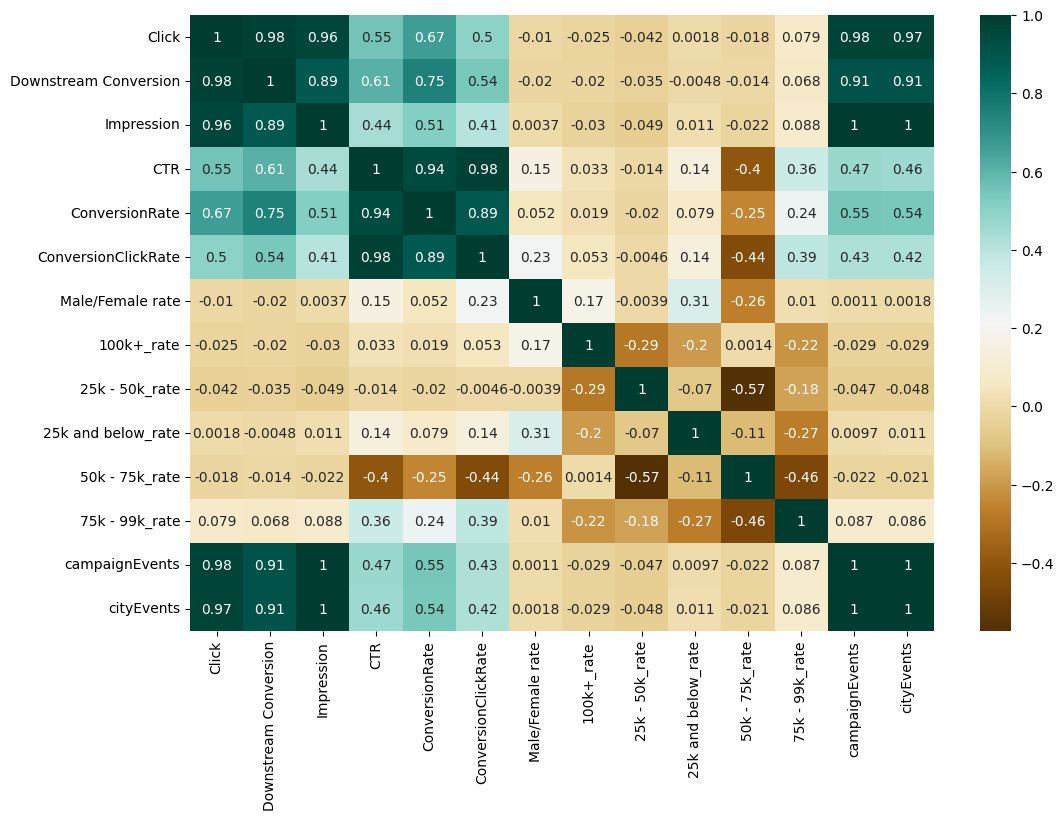

In [ ]:
c0 = final_df0.corr()
plt.figure(figsize=(12,8))
sns.heatmap(c0,cmap="BrBG",annot=True)

In this correlation, we can see that from the -0.4 between the 50-75k rate and ctr, gets a lot of impressions but a lot less clicks also, while the 0.36 and 0.39 show that 75k-90k rate tends to click more and also convert more, for day 1

# Day 2

## Loading the data and basic overview

In [ ]:
df_events = pd.read_parquet("/content/drive/MyDrive/task3/events/day5.parquet")
df_events = df_events.sample(frac=0.6, random_state=88)
df_campaign = pd.read_csv("/content/drive/MyDrive/task3/campaigns.csv")

## Merging the data

In [ ]:
df_merged = pd.merge(
    df_events.rename(columns={"campaign": "campaign_id"}),
    df_campaign,
    on="campaign_id",
    how="left"
)

## Dropping any null values to analyze

In [ ]:
df_merged = df_merged.dropna()

## Strategy

The focus will be in creating visualization for the advertisers, suchs as CTR, Conversions, numbers of men, woman, incomes and analyze them

### Feature engineering Location

Since city and country are correlated, we group them into 1 column to analyse

In [ ]:
df_merged["Location"] = df_merged["region"] + " - " + df_merged["country"]

### General Visualization

In [ ]:
pivoted_dfs = []
columns = list(df_merged.columns)
columns.remove("advertiser")
columns.remove("user_id")
columns.remove("page_url")
columns.remove("campaign_id")
columns.remove("region")
columns.remove("country")
for column in columns:
  grouped = df_merged.groupby(['advertiser', column]).size().reset_index(name='count')
  pivot_table = grouped.pivot_table(index='advertiser', columns=column, values='count', fill_value=0).reset_index()
  pivot_table.columns.name = None
  pivoted_dfs.append(pivot_table)

### Calculating CTR, conversion rate, and conversion rate per click

In [ ]:
pivoted_dfs[0]["CTR"] = pivoted_dfs[0]["Click"]/pivoted_dfs[0]["Impression"]
pivoted_dfs[0]["ConversionRate"] = pivoted_dfs[0]["Downstream Conversion"]/pivoted_dfs[0]["Impression"]
pivoted_dfs[0]["ConversionClickRate"] = pivoted_dfs[0]["Downstream Conversion"]/pivoted_dfs[0]["Click"]

### Calculating the Male/Female targeting rate to see what's the gender that is most consuming the ad(Ignoring unknown)

In [ ]:
pivoted_dfs[1]["Male/Female rate"] = pivoted_dfs[1]["Male"]/pivoted_dfs[1]["Female"]
pivoted_dfs[1] = pivoted_dfs[1][["advertiser", "Male/Female rate"]]

### Calculating the rate for the distribution between incomes

In [ ]:
columns = list(pivoted_dfs[2].drop(columns=["advertiser", "unknown"]).columns)
for column in columns:
  pivoted_dfs[2][f"{column}_rate"] = pivoted_dfs[2][column]/(pivoted_dfs[2][columns[0]] + pivoted_dfs[2][columns[1]] + pivoted_dfs[2][columns[2]] + pivoted_dfs[2][columns[3]] + pivoted_dfs[2][columns[4]])
pivoted_dfs[2] = pivoted_dfs[2][["advertiser"] + [f"{c}_rate" for c in columns]]

### Retrieving the best engaged city and the number of events it had

In [ ]:
df = pivoted_dfs[4].drop(columns=['advertiser'])
def max_column_with_value(row):
    max_column = row.idxmax()
    max_value = row[max_column]
    return pd.Series([max_column, max_value], index=['cityMostEngaged', 'cityEvents'])

max_columns = df.apply(max_column_with_value, axis=1)
pivoted_dfs[4] = pd.concat([pivoted_dfs[4]['advertiser'], max_columns], axis=1)

In [ ]:
df = pivoted_dfs[3].drop(columns=['advertiser'])
def max_column_with_value(row):
    max_column = row.idxmax()
    max_value = row[max_column]
    return pd.Series([max_column, max_value], index=['campaignMostEngaged', 'campaignEvents'])

max_columns = df.apply(max_column_with_value, axis=1)
pivoted_dfs[3] = pd.concat([pivoted_dfs[3]['advertiser'], max_columns], axis=1)

In [ ]:
final_df1 = pivoted_dfs[0]
for i, dfp in enumerate(pivoted_dfs[1:]):
  final_df1 = pd.merge(final_df1, dfp, on="advertiser", how="left")
final_df1.head()

,advertiser,Click,Downstream Conversion,Impression,CTR,ConversionRate,ConversionClickRate,Male/Female rate,100k+_rate,25k - 50k_rate,25k and below_rate,50k - 75k_rate,75k - 99k_rate,campaignMostEngaged,campaignEvents,cityMostEngaged,cityEvents
0,7-Eleven,3602,1193,37628,0.095727,0.031705,0.331205,1.554404,0.110784,0.225614,0.113285,0.327681,0.222635,dream burger,10106,California - US,5163
1,A&P,123,42,1311,0.093822,0.032037,0.341463,1.440605,0.110759,0.237342,0.102321,0.339662,0.209916,dream burger,371,California - US,184
2,AT&T Wireless,925,326,9837,0.094033,0.033140,0.352432,1.544428,0.105940,0.230632,0.110731,0.342048,0.210649,dream burger,2662,California - US,1409
3,AVB Brandsource,1326,423,13730,0.096577,0.030808,0.319005,1.600477,0.107559,0.217431,0.118818,0.331323,0.224869,dream burger,3729,California - US,1962
4,Ace Hardware,1916,614,19566,0.097925,0.031381,0.320459,1.538792,0.110559,0.226856,0.114478,0.329088,0.219019,dream burger,5261,California - US,2801


## Analysis with the Advertiser strategy

<ipython-input-246-8b90fe918323>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  c1 = final_df1.corr()


<Axes: >

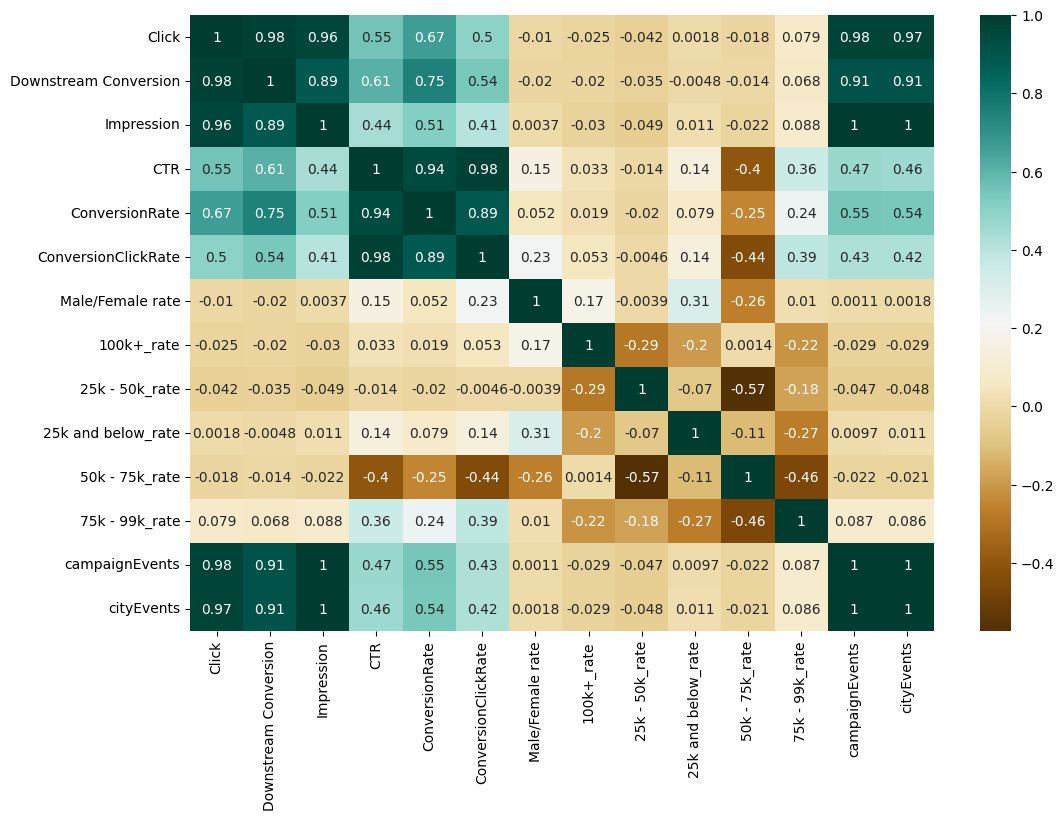

In [ ]:
c1 = final_df1.corr()
plt.figure(figsize=(12,8))
sns.heatmap(c0,cmap="BrBG",annot=True)

In this correlation, we can see that from the -0.4 between the 50-75k rate and ctr, gets a lot of impressions but a lot less clicks also, while the 0.36 and 0.39 show that 75k-90k rate tends to click more and also convert more, for day 1

# Day 3


## Loading the data and basic overview

In [ ]:
df_events = pd.read_parquet("/content/drive/MyDrive/task3/events/day8.parquet")
df_events = df_events.sample(frac=0.7, random_state=88)
df_campaign = pd.read_csv("/content/drive/MyDrive/task3/campaigns.csv")

## Merging the data

In [ ]:
df_merged = pd.merge(
    df_events.rename(columns={"campaign": "campaign_id"}),
    df_campaign,
    on="campaign_id",
    how="left"
)

## Dropping any null values to analyze

In [ ]:
df_merged = df_merged.dropna()

## Strategy

The focus will be in creating visualization for the advertisers, suchs as CTR, Conversions, numbers of men, woman, incomes and analyze them

### Feature engineering Location

Since city and country are correlated, we group them into 1 column to analyse

In [ ]:
df_merged["Location"] = df_merged["region"] + " - " + df_merged["country"]

### General Visualization

In [ ]:
pivoted_dfs = []
columns = list(df_merged.columns)
columns.remove("advertiser")
columns.remove("user_id")
columns.remove("page_url")
columns.remove("campaign_id")
columns.remove("region")
columns.remove("country")
for column in columns:
  grouped = df_merged.groupby(['advertiser', column]).size().reset_index(name='count')
  pivot_table = grouped.pivot_table(index='advertiser', columns=column, values='count', fill_value=0).reset_index()
  pivot_table.columns.name = None
  pivoted_dfs.append(pivot_table)

### Calculating CTR, conversion rate, and conversion rate per click

In [ ]:
pivoted_dfs[0]["CTR"] = pivoted_dfs[0]["Click"]/pivoted_dfs[0]["Impression"]
pivoted_dfs[0]["ConversionRate"] = pivoted_dfs[0]["Downstream Conversion"]/pivoted_dfs[0]["Impression"]
pivoted_dfs[0]["ConversionClickRate"] = pivoted_dfs[0]["Downstream Conversion"]/pivoted_dfs[0]["Click"]

### Calculating the Male/Female targeting rate to see what's the gender that is most consuming the ad(Ignoring unknown)

In [ ]:
pivoted_dfs[1]["Male/Female rate"] = pivoted_dfs[1]["Male"]/pivoted_dfs[1]["Female"]
pivoted_dfs[1] = pivoted_dfs[1][["advertiser", "Male/Female rate"]]

### Calculating the rate for the distribution between incomes

In [ ]:
columns = list(pivoted_dfs[2].drop(columns=["advertiser", "unknown"]).columns)
for column in columns:
  pivoted_dfs[2][f"{column}_rate"] = pivoted_dfs[2][column]/(pivoted_dfs[2][columns[0]] + pivoted_dfs[2][columns[1]] + pivoted_dfs[2][columns[2]] + pivoted_dfs[2][columns[3]] + pivoted_dfs[2][columns[4]])
pivoted_dfs[2] = pivoted_dfs[2][["advertiser"] + [f"{c}_rate" for c in columns]]

### Retrieving the best engaged city and the number of events it had

In [ ]:
df = pivoted_dfs[4].drop(columns=['advertiser'])
def max_column_with_value(row):
    max_column = row.idxmax()
    max_value = row[max_column]
    return pd.Series([max_column, max_value], index=['cityMostEngaged', 'cityEvents'])

max_columns = df.apply(max_column_with_value, axis=1)
pivoted_dfs[4] = pd.concat([pivoted_dfs[4]['advertiser'], max_columns], axis=1)

In [ ]:
df = pivoted_dfs[3].drop(columns=['advertiser'])
def max_column_with_value(row):
    max_column = row.idxmax()
    max_value = row[max_column]
    return pd.Series([max_column, max_value], index=['campaignMostEngaged', 'campaignEvents'])

max_columns = df.apply(max_column_with_value, axis=1)
pivoted_dfs[3] = pd.concat([pivoted_dfs[3]['advertiser'], max_columns], axis=1)

In [ ]:
final_df2 = pivoted_dfs[0]
for i, dfp in enumerate(pivoted_dfs[1:]):
  final_df2 = pd.merge(final_df2, dfp, on="advertiser", how="left")
final_df2.head()

,advertiser,Click,Downstream Conversion,Impression,CTR,ConversionRate,ConversionClickRate,Male/Female rate,100k+_rate,25k - 50k_rate,25k and below_rate,50k - 75k_rate,75k - 99k_rate,campaignMostEngaged,campaignEvents,cityMostEngaged,cityEvents
0,7-Eleven,4210,1403,43912,0.095874,0.031950,0.333254,1.553848,0.110044,0.223248,0.111640,0.333667,0.221402,dream burger,11736,California - US,6105
1,A&P,141,51,1539,0.091618,0.033138,0.361702,1.590909,0.118433,0.221728,0.098842,0.339270,0.221728,dream burger,425,California - US,218
2,AT&T Wireless,1096,369,11519,0.095147,0.032034,0.336679,1.510713,0.106206,0.228551,0.110478,0.338911,0.215854,dream burger,3136,California - US,1578
3,AVB Brandsource,1554,491,16057,0.096780,0.030579,0.315959,1.531053,0.106651,0.220361,0.112264,0.336537,0.224188,dream burger,4405,California - US,2341
4,Ace Hardware,2197,745,22746,0.096588,0.032753,0.339099,1.524350,0.103911,0.225533,0.119386,0.332104,0.219065,dream burger,6076,California - US,3304


## Analysis with the Advertiser strategy

<ipython-input-258-e24591550aa7>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  c2 = final_df2.corr()


<Axes: >

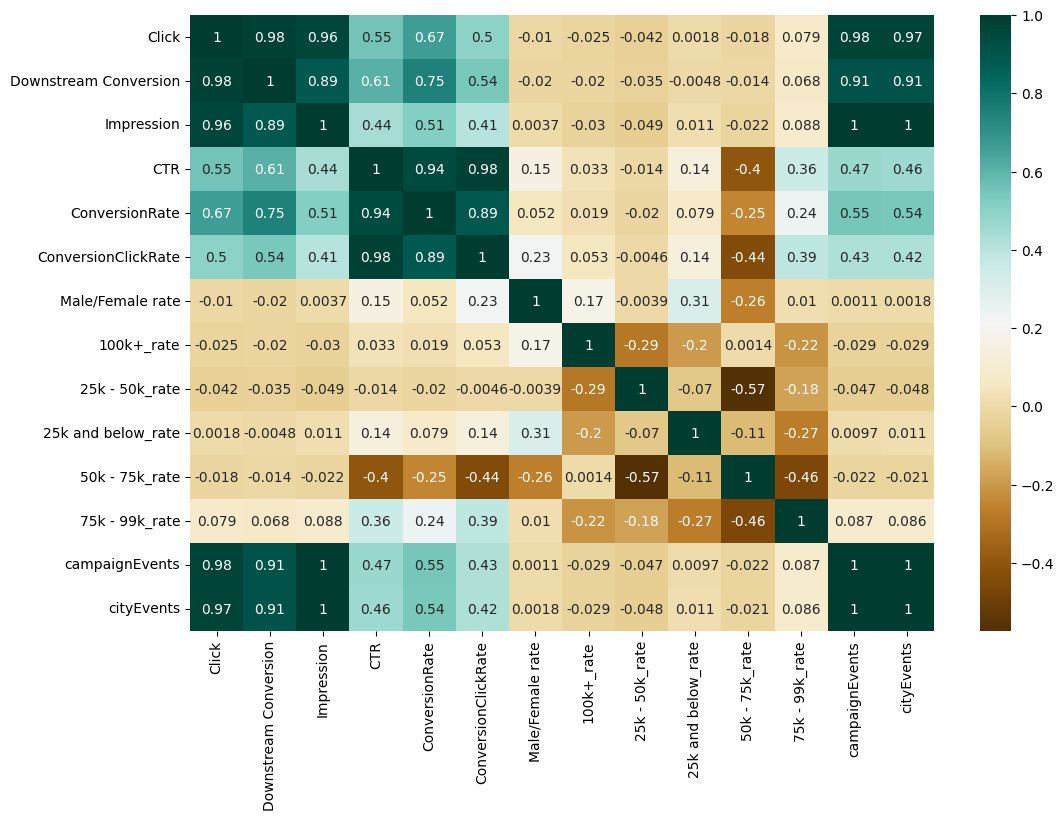

In [ ]:
c2 = final_df2.corr()
plt.figure(figsize=(12,8))
sns.heatmap(c0,cmap="BrBG",annot=True)

In this correlation, we can see that from the -0.4 between the 50-75k rate and ctr, gets a lot of impressions but a lot less clicks also, while the 0.36 and 0.39 show that 75k-90k rate tends to click more and also convert more, for day 1

# Comparing curves

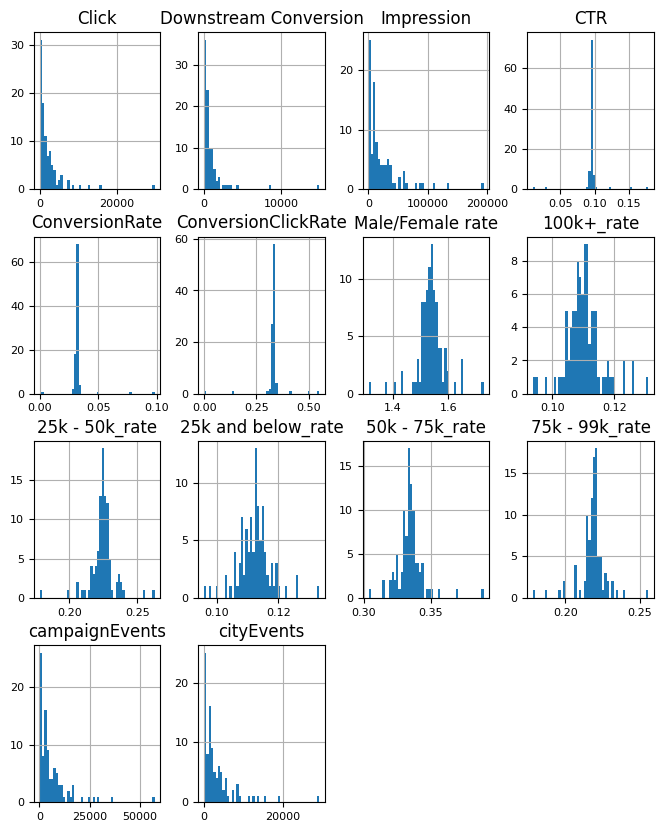

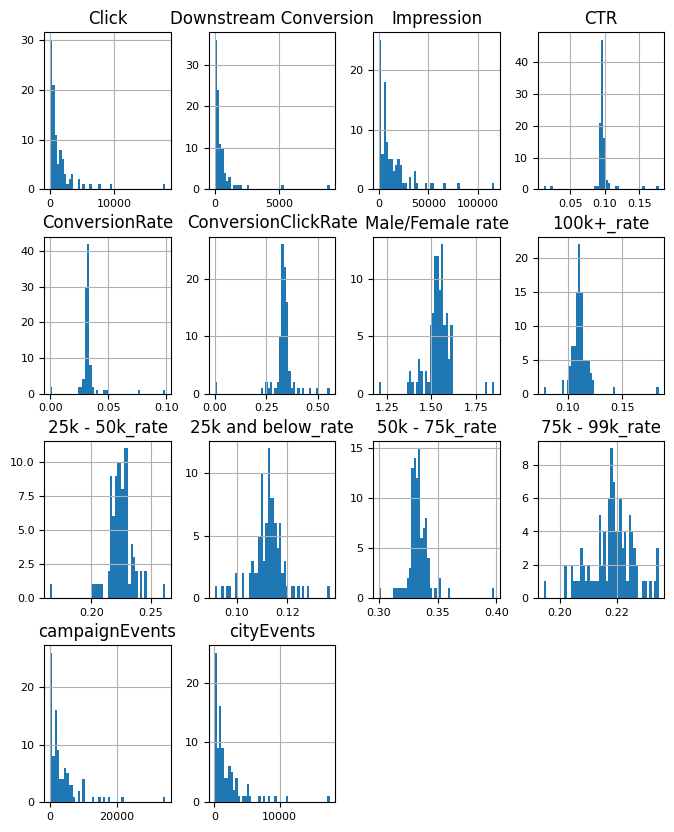

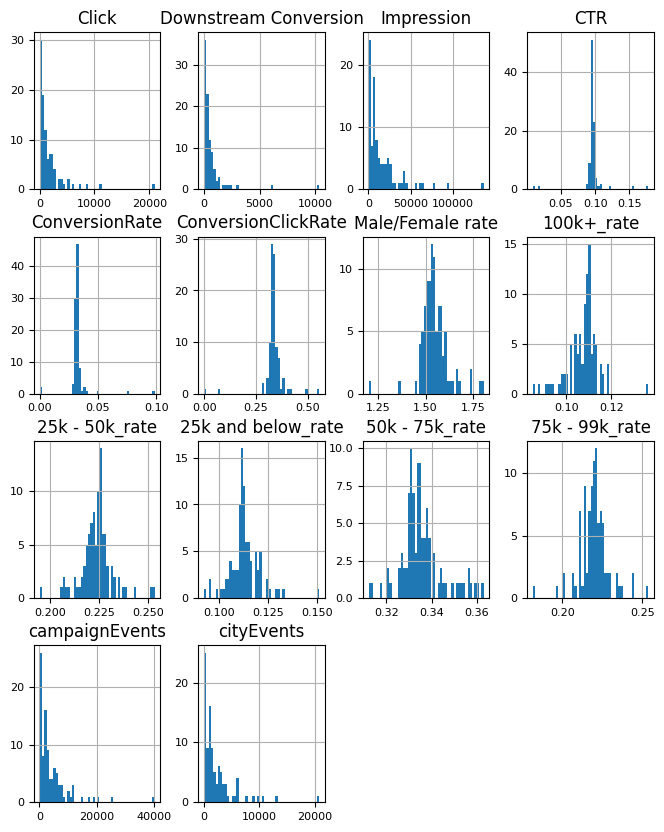

In [ ]:
for i, df in enumerate([final_df0, final_df1, final_df2]):
  df.hist(figsize=(8, 10), bins=50, xlabelsize=8, ylabelsize=8)

We can see some distribution changes between the days(batchs) but the avegare stays a lot the same for the general events analysis, making and in-depth analysis for a specific advertiser it can change